# Forecast Using the Chronos Family

## Import libraries

In [5]:
import pandas as pd
import numpy as np 
from timecopilot import TimeCopilotForecaster


## Load the dataset 

The DataFrame must include at least the following columns:
- unique_id: Unique identifier for each time series (string)
- ds: Date column (datetime format)
- y: Target variable for forecasting (float format)

The pandas frequency will be inferred from the ds column, if not provided.
If the seasonality is not provided, it will be inferred based on the frequency. 
If the horizon is not set, it will default to 2 times the inferred seasonality.

In [6]:
df = pd.read_csv(
    "https://timecopilot.s3.amazonaws.com/public/data/events_pageviews.csv",
    parse_dates=["ds"],
)
df.head()


,unique_id,ds,y
0,Oktoberfest,2020-01-31,25376
1,Oktoberfest,2020-02-29,28470
2,Oktoberfest,2020-03-31,23816
3,Oktoberfest,2020-04-30,46186
4,Oktoberfest,2020-05-31,31213


## Plot the data

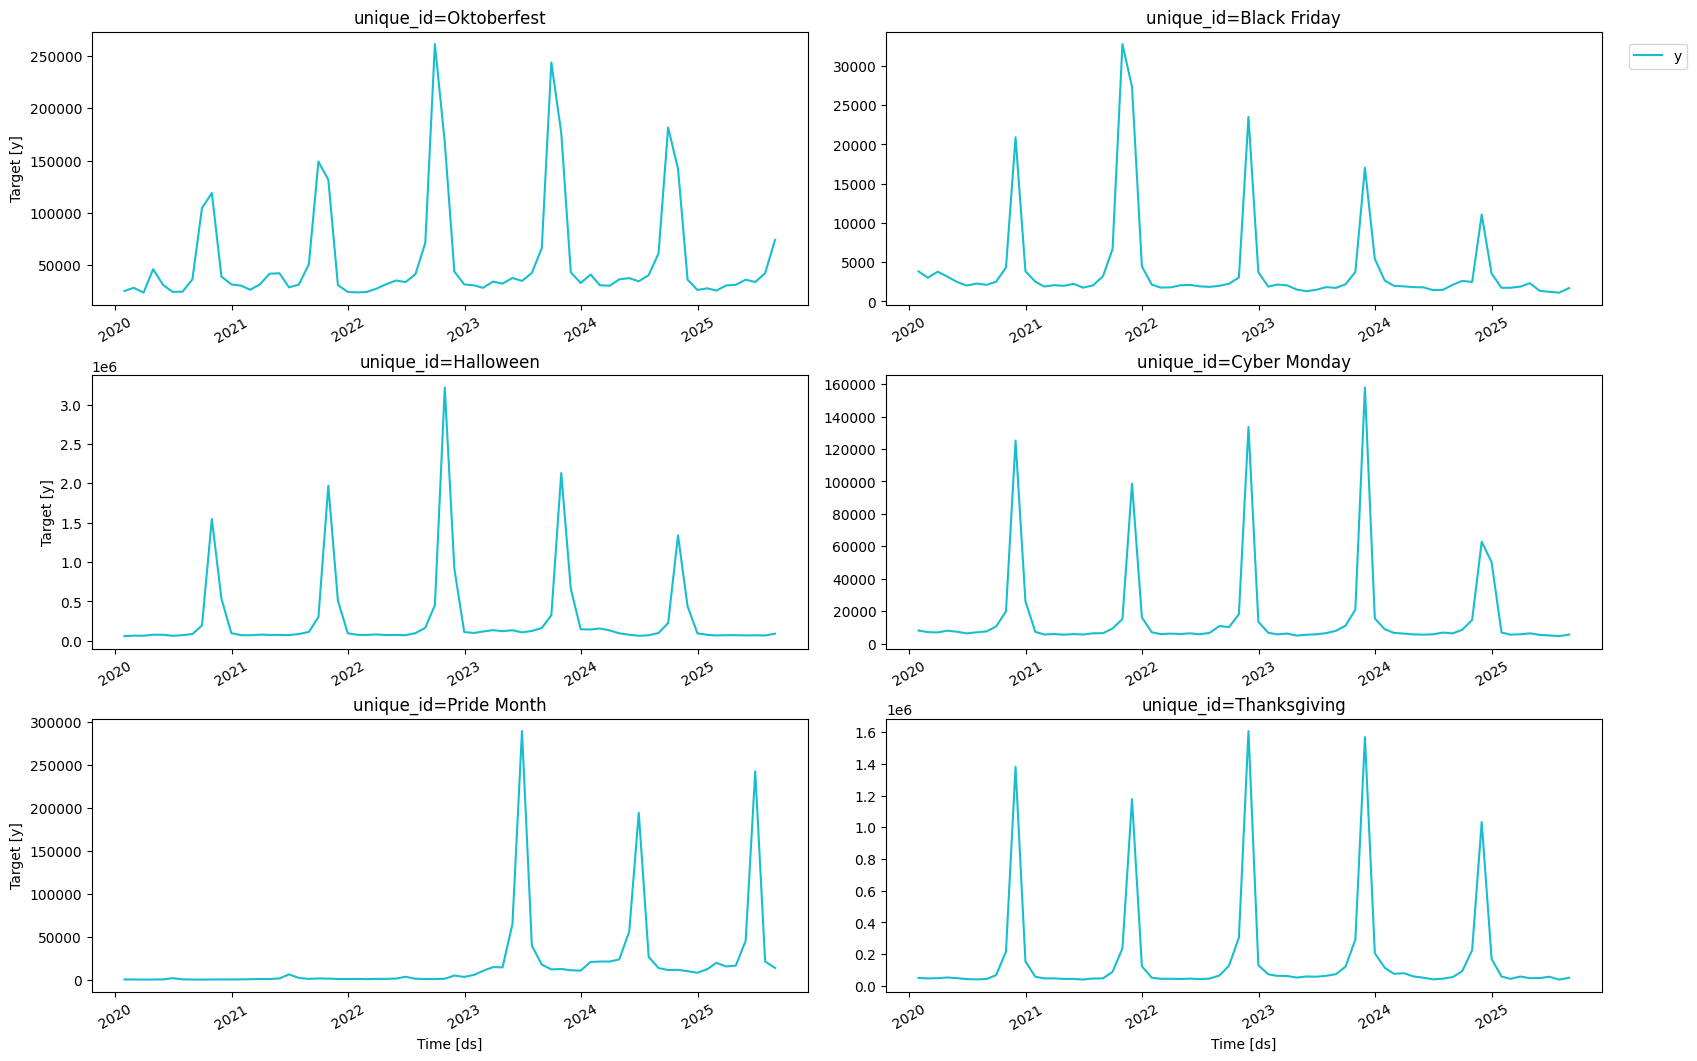

In [9]:
TimeCopilotForecaster.plot(df)

## Import the Chronos class 

In [10]:
from timecopilot.models.foundation.chronos import Chronos
from timecopilot.models.stats import SeasonalNaive

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.



## Create a TimeCopilotForecaster


In [11]:
chronos_av_models = [
    "amazon/chronos-2",
    # "amazon/chronos-bolt-tiny",
    # "amazon/chronos-bolt-mini",
    # "amazon/chronos-bolt-small",
    # "amazon/chronos-bolt-base",
    # "amazon/chronos-t5-tiny",
    # "amazon/chronos-t5-mini",
    # "amazon/chronos-t5-small",
    # "amazon/chronos-t5-base",
    # "amazon/chronos-t5-large",
]
chronos_models = [Chronos(repo_id=model, alias=model) for model in chronos_av_models]
models = chronos_models + [SeasonalNaive()]


tcf = TimeCopilotForecaster(models=models)


## Generate forecast 

You can optionally specify the following parameters:
- freq: The frequency of your data (e.g., 'D' for daily, 'M' for monthly)
- h: The forecast horizon, which is the number of periods to predict
- seasonality: The seasonal period of your data, which can be inferred if not provided


In [6]:
level = [20, 40, 60, 80]
cv_df = tcf.cross_validation(df=df, h=12, level=level) 

0it [00:00, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
100%|██████████| 1/1 [00:06<00:00,  6.34s/it]
1it [00:08,  8.76s/it]
1it [00:02,  2.00s/it]


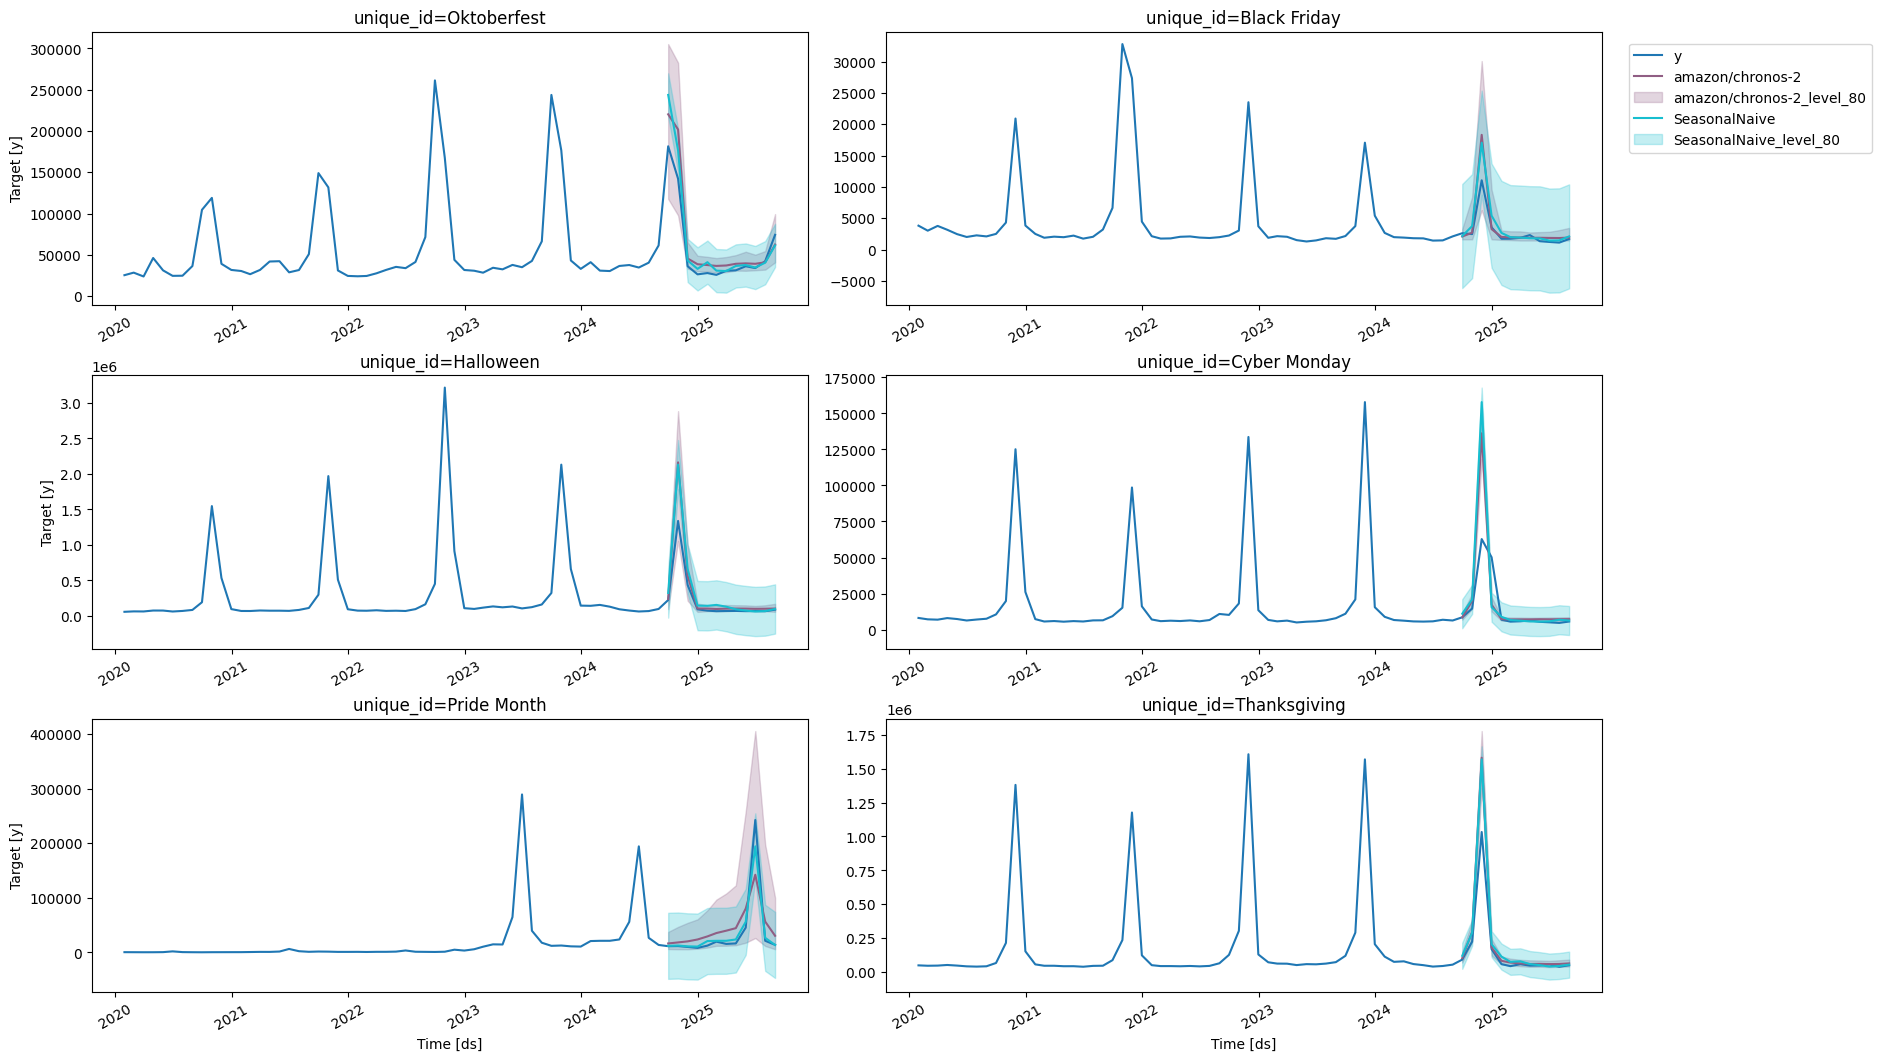

In [7]:
tcf.plot(df, cv_df.drop(columns=["cutoff", "y"]), level=[80])

In [8]:
cv_df.head()

,unique_id,ds,cutoff,y,amazon/chronos-2,amazon/chronos-2-lo-20,amazon/chronos-2-hi-20,amazon/chronos-2-lo-40,amazon/chronos-2-hi-40,amazon/chronos-2-lo-60,...,amazon/chronos-2-hi-80,SeasonalNaive,SeasonalNaive-lo-20,SeasonalNaive-lo-40,SeasonalNaive-lo-60,SeasonalNaive-lo-80,SeasonalNaive-hi-20,SeasonalNaive-hi-40,SeasonalNaive-hi-60,SeasonalNaive-hi-80
0,Black Friday,2024-09-30,2024-08-31,2607,2080.0,1992.0,2176.0,1896.0,2288.0,1784.0,...,3264.0,2160.0,518.105774,-1238.539551,-3294.386475,-6145.491211,3801.894287,5558.539551,7614.386719,10465.491211
1,Black Friday,2024-10-31,2024-08-31,2470,2688.0,2320.0,3328.0,2048.0,4352.0,1856.0,...,8384.0,3746.0,2104.105713,347.460388,-1708.386475,-4559.491211,5387.894043,7144.539551,9200.386719,12051.491211
2,Black Friday,2024-11-30,2024-08-31,11058,18304.0,15936.0,20352.0,12352.0,22784.0,9152.0,...,30080.0,17053.0,15411.105469,13654.459961,11598.613281,8747.508789,18694.894531,20451.539062,22507.386719,25358.490234
3,Black Friday,2024-12-31,2024-08-31,3548,3264.0,2736.0,4160.0,2352.0,5376.0,1992.0,...,9536.0,5407.0,3765.105713,2008.460449,-47.386536,-2898.490967,7048.894043,8805.540039,10861.386719,13712.491211
4,Black Friday,2025-01-31,2024-08-31,1724,2008.0,1912.0,2080.0,1816.0,2192.0,1688.0,...,3040.0,2656.0,1014.105774,-742.539612,-2798.386475,-5649.491211,4297.894043,6054.539551,8110.386719,10961.491211


## Evaluation

In [9]:
from functools import partial

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mase, scaled_crps

In [10]:
eval_df = evaluate(
    cv_df.drop(columns=["cutoff"]), 
    train_df=df.query("ds <= '2024-08-31'"), 
    metrics=[partial(mase, seasonality=12), scaled_crps],
    level=level,
)
eval_df.groupby("metric").mean(numeric_only=True).T.sort_values(by="scaled_crps").round(3)

metric,mase,scaled_crps
amazon/chronos-2,1.648,0.360
SeasonalNaive,1.576,0.521


New part for checking exagenous feature.

In [ ]:
df["month"] = df["ds"].dt.month
df["is_holiday_season"] = df["ds"].dt.month.isin([11, 12]).astype(int)
df["noise_feature"] = np.random.randn(len(df))

In [ ]:
from timecopilot import TimeCopilotForecaster
from timecopilot.models.foundation.chronos import Chronos



models = [Chronos(repo_id="amazon/chronos-2", alias="amazon/chronos-2")]
tcf = TimeCopilotForecaster(models=models)

cv_df = tcf.cross_validation(df=df, h=12, level=[20,40,60,80])


1it [00:10, 10.08s/it]


In [14]:
cv_df

,unique_id,ds,cutoff,y,amazon/chronos-2,amazon/chronos-2-lo-20,amazon/chronos-2-hi-20,amazon/chronos-2-lo-40,amazon/chronos-2-hi-40,amazon/chronos-2-lo-60,amazon/chronos-2-hi-60,amazon/chronos-2-lo-80,amazon/chronos-2-hi-80
0,Black Friday,2024-09-30,2024-08-31,2607,2096.0,1992.0,2240.0,1880.0,2416.0,1760.0,2784.0,1536.0,3600.0
1,Black Friday,2024-10-31,2024-08-31,2470,4544.0,3712.0,5536.0,3008.0,6784.0,2448.0,8448.0,1912.0,11200.0
2,Black Friday,2024-11-30,2024-08-31,11058,20224.0,18432.0,21888.0,15680.0,24064.0,12800.0,26624.0,9664.0,30848.0
3,Black Friday,2024-12-31,2024-08-31,3548,3680.0,3200.0,4320.0,2752.0,5280.0,2320.0,6656.0,1856.0,8704.0
4,Black Friday,2025-01-31,2024-08-31,1724,2008.0,1912.0,2080.0,1800.0,2208.0,1672.0,2400.0,1496.0,2960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Thanksgiving,2025-04-30,2024-08-31,47655,61184.0,56832.0,66048.0,51712.0,72192.0,45056.0,79360.0,35328.0,93184.0
68,Thanksgiving,2025-05-31,2024-08-31,48667,61952.0,56832.0,67072.0,51712.0,71168.0,45056.0,79360.0,36096.0,92160.0
69,Thanksgiving,2025-06-30,2024-08-31,56856,61184.0,56064.0,67072.0,50944.0,72192.0,44288.0,79360.0,34560.0,90112.0
70,Thanksgiving,2025-07-31,2024-08-31,38935,65536.0,61184.0,71168.0,55296.0,76288.0,48640.0,84480.0,38144.0,97280.0
